In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import datetime
sns.set_style("dark")




from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, RandomizedSearchCV, KFold, cross_validate, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('bmw.csv')

train, test = train_test_split(df, test_size=0.3, random_state=2020)

print('train shape: {}'.format(train.shape))
print('test shape: {}'.format(test.shape))

train.sample(n=5)

train shape: (7546, 9)
test shape: (3235, 9)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
8718,3 Series,2016,19000,Automatic,26114,Diesel,145,53.3,3.0
7237,X5,2019,52875,Semi-Auto,13,Diesel,150,37.7,3.0
1275,X2,2019,29770,Automatic,123,Diesel,145,48.7,2.0
5345,2 Series,2019,21950,Semi-Auto,7423,Diesel,145,65.7,2.0
1974,1 Series,2019,26980,Automatic,1250,Petrol,145,40.4,1.5


In [3]:
train['model'].unique()

array([' 2 Series', ' 3 Series', ' X1', ' 5 Series', ' X5', ' 7 Series',
       ' 4 Series', ' 1 Series', ' X3', ' 6 Series', ' X2', ' M4', ' X6',
       ' M5', ' M2', ' X4', ' i3', ' M3', ' X7', ' Z4', ' 8 Series',
       ' i8', ' M6', ' Z3'], dtype=object)

In [4]:
# remove space before model name
train['model'] = train['model'].apply(lambda x: x.strip())
train['model'].unique()

array(['2 Series', '3 Series', 'X1', '5 Series', 'X5', '7 Series',
       '4 Series', '1 Series', 'X3', '6 Series', 'X2', 'M4', 'X6', 'M5',
       'M2', 'X4', 'i3', 'M3', 'X7', 'Z4', '8 Series', 'i8', 'M6', 'Z3'],
      dtype=object)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 4613 to 9056
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         7546 non-null   object 
 1   year          7546 non-null   int64  
 2   price         7546 non-null   int64  
 3   transmission  7546 non-null   object 
 4   mileage       7546 non-null   int64  
 5   fuelType      7546 non-null   object 
 6   tax           7546 non-null   int64  
 7   mpg           7546 non-null   float64
 8   engineSize    7546 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 589.5+ KB


In [6]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 4613 to 9056
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         7546 non-null   object 
 1   year          7546 non-null   int64  
 2   price         7546 non-null   int64  
 3   transmission  7546 non-null   object 
 4   mileage       7546 non-null   int64  
 5   fuelType      7546 non-null   object 
 6   tax           7546 non-null   int64  
 7   mpg           7546 non-null   float64
 8   engineSize    7546 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 589.5+ KB


In [8]:
train.apply(lambda x: x.nunique(), axis=0)

model             24
year              24
price           2997
transmission       3
mileage         5826
fuelType           5
tax               36
mpg               98
engineSize        17
dtype: int64

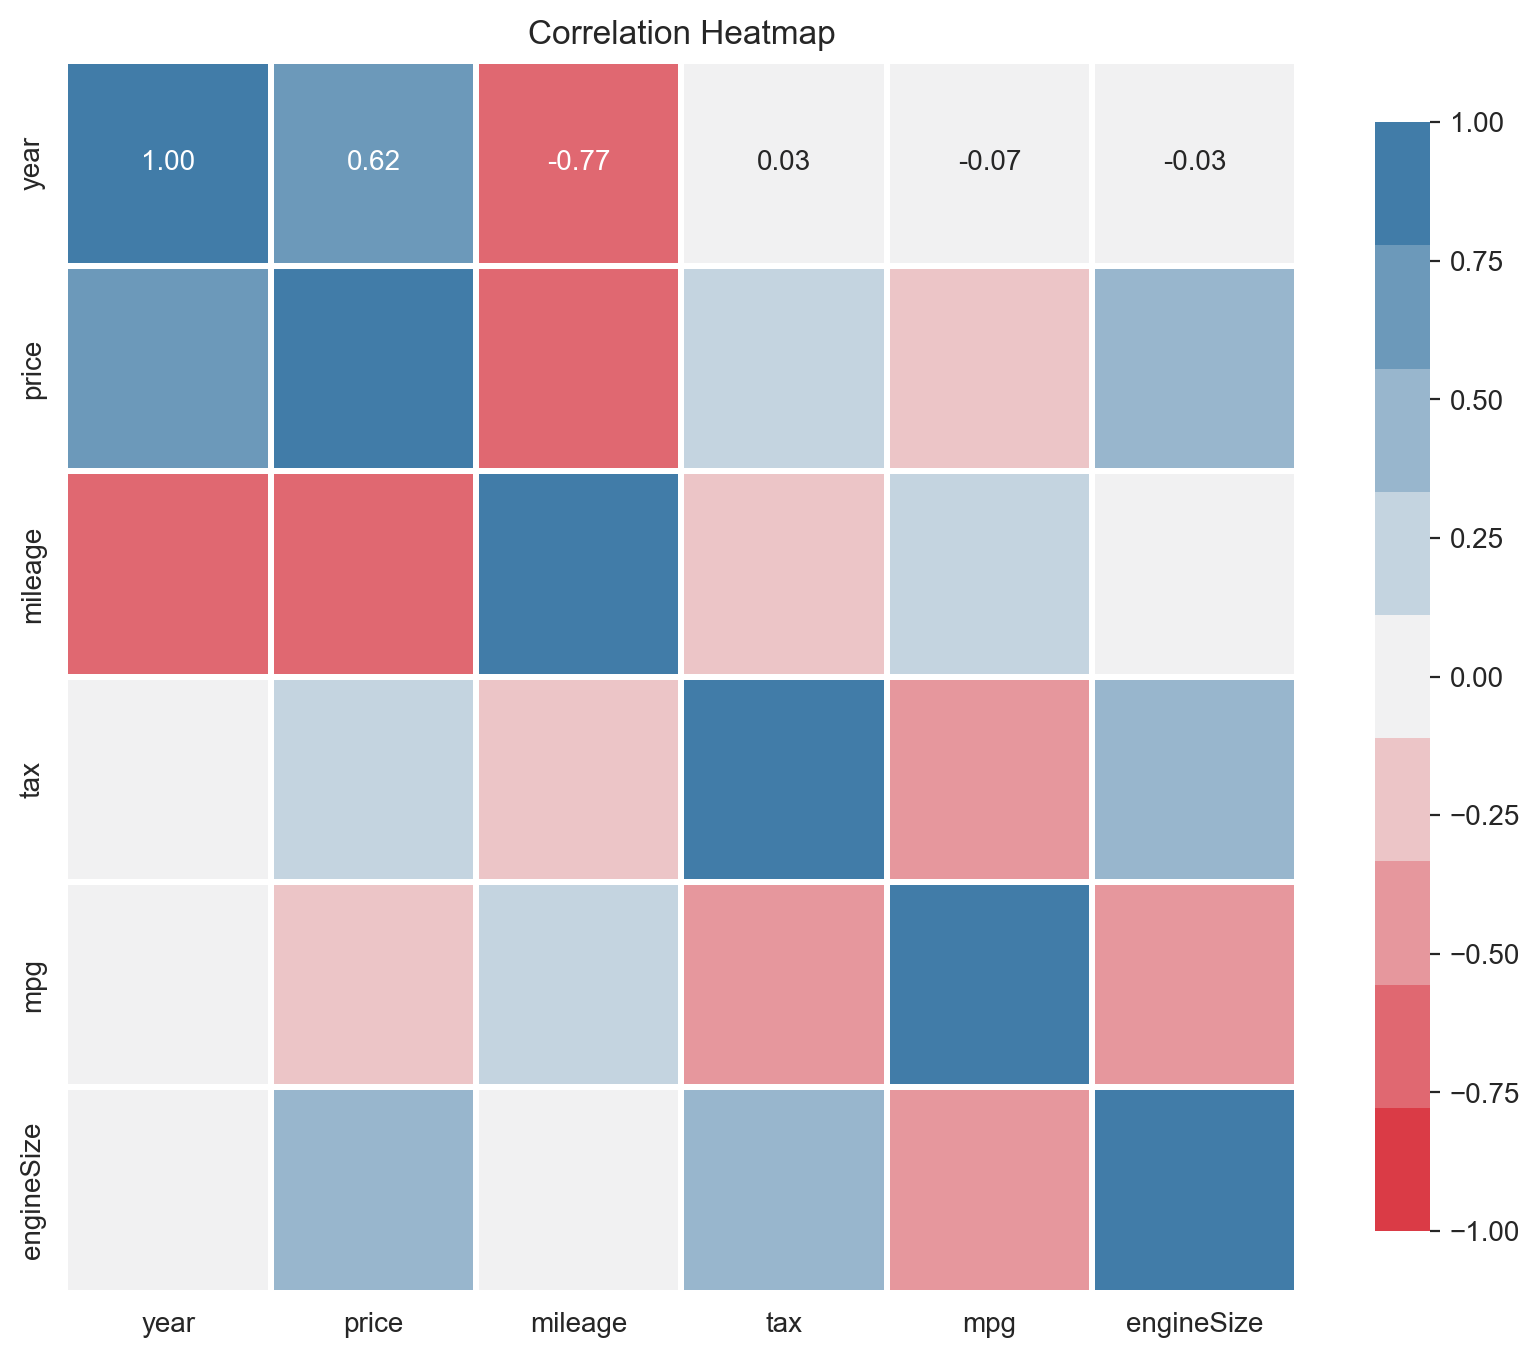

In [9]:
# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=['number'])

# Define the colormap
cmap = sns.diverging_palette(10, 240, n=9)

# Compute correlation matrix
train_corr = numeric_df.corr()

# Plot heat map
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr, annot=True, fmt=".2f", 
            linewidths=2, cmap=cmap, vmin=-1, vmax=1, 
            cbar_kws={"shrink": .9}, square=True)
plt.title('Correlation Heatmap')
plt.show()


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_(df, col, y='price'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90) 
    fig.suptitle(str(col) + ' vs price')

    if df[col].dtype == 'object':  # Check if the column type is object (categorical)
        sns.barplot(data=df, x=col, y=y, ax=ax[0])
        sns.countplot(data=df, x=col, ax=ax[1])
    elif len(df[col].unique()) <= 10:  # If the column has less than or equal to 10 unique values
        sns.barplot(data=df, x=col, y=y, ax=ax[0])
        sns.countplot(data=df, x=col, ax=ax[1])
    else:  # For numerical columns or columns with more than 10 unique values
        sns.barplot(data=df, x=col, y=y, ax=ax[0])
        sns.histplot(data=df, x=col, ax=ax[1])




In [11]:
# Get numerical columns
num_col = [col for col in train.columns if train[col].dtype != 'object']
print('Numerical Columns\n'+ str(num_col))

# Get categorical columns
cat_col = [col for col in train.columns if train[col].dtype == 'object']
print('\nCategorical Columns\n'+ str(cat_col))

Numerical Columns
['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']

Categorical Columns
['model', 'transmission', 'fuelType']


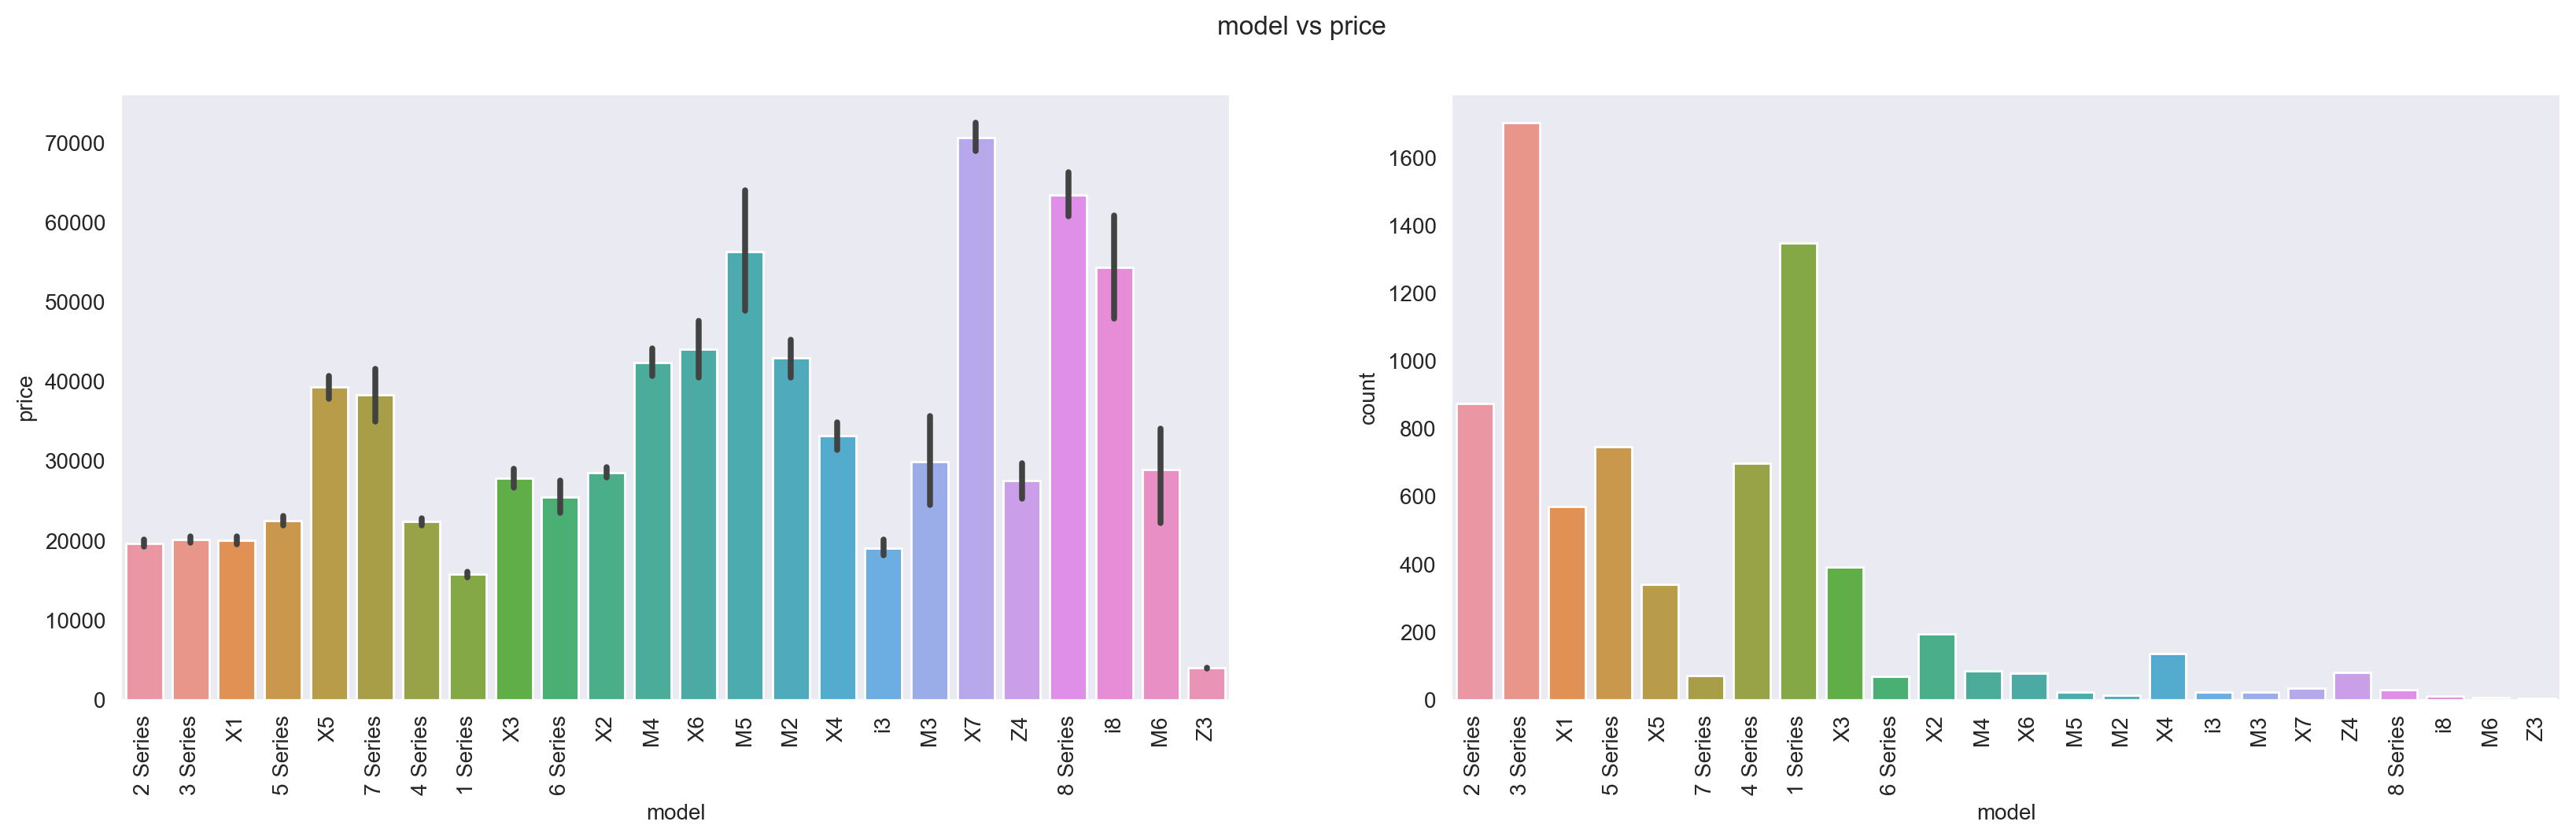

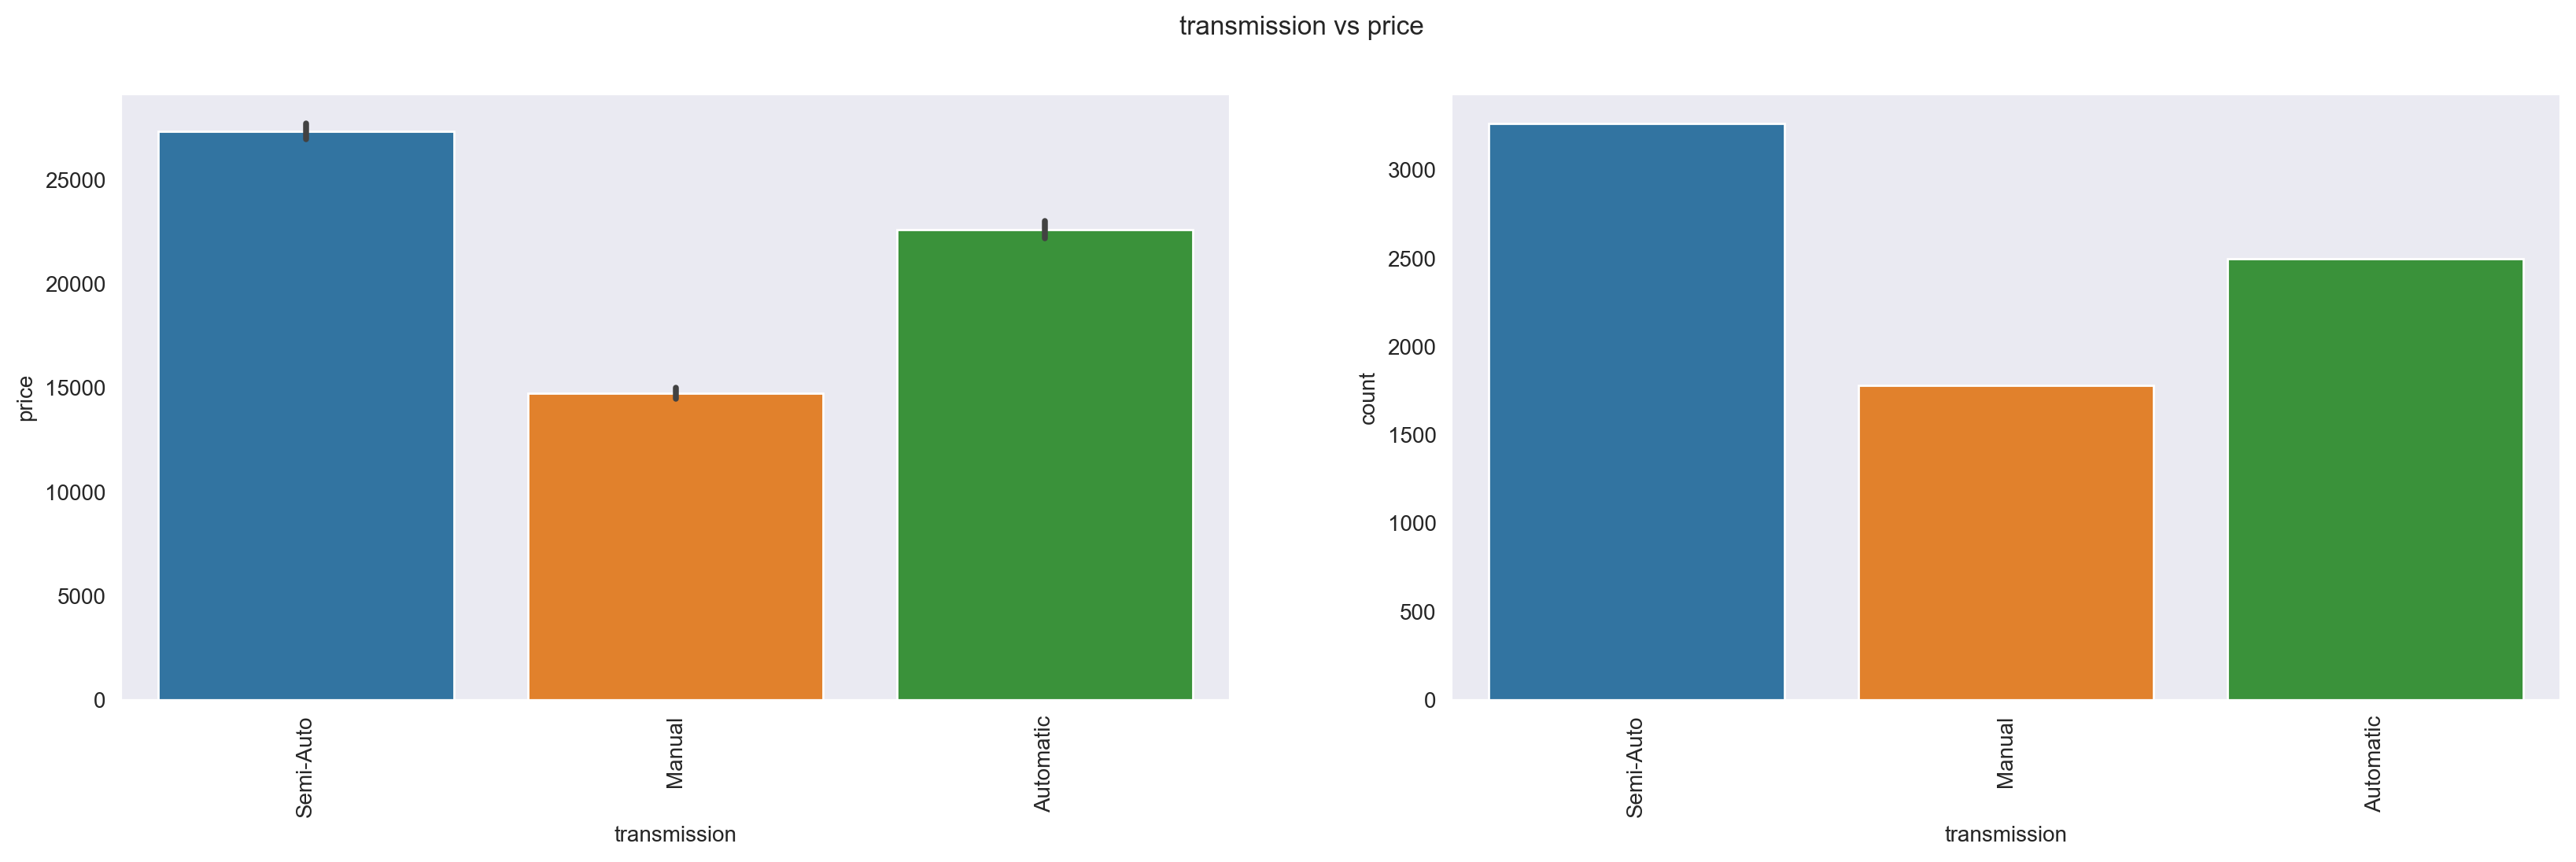

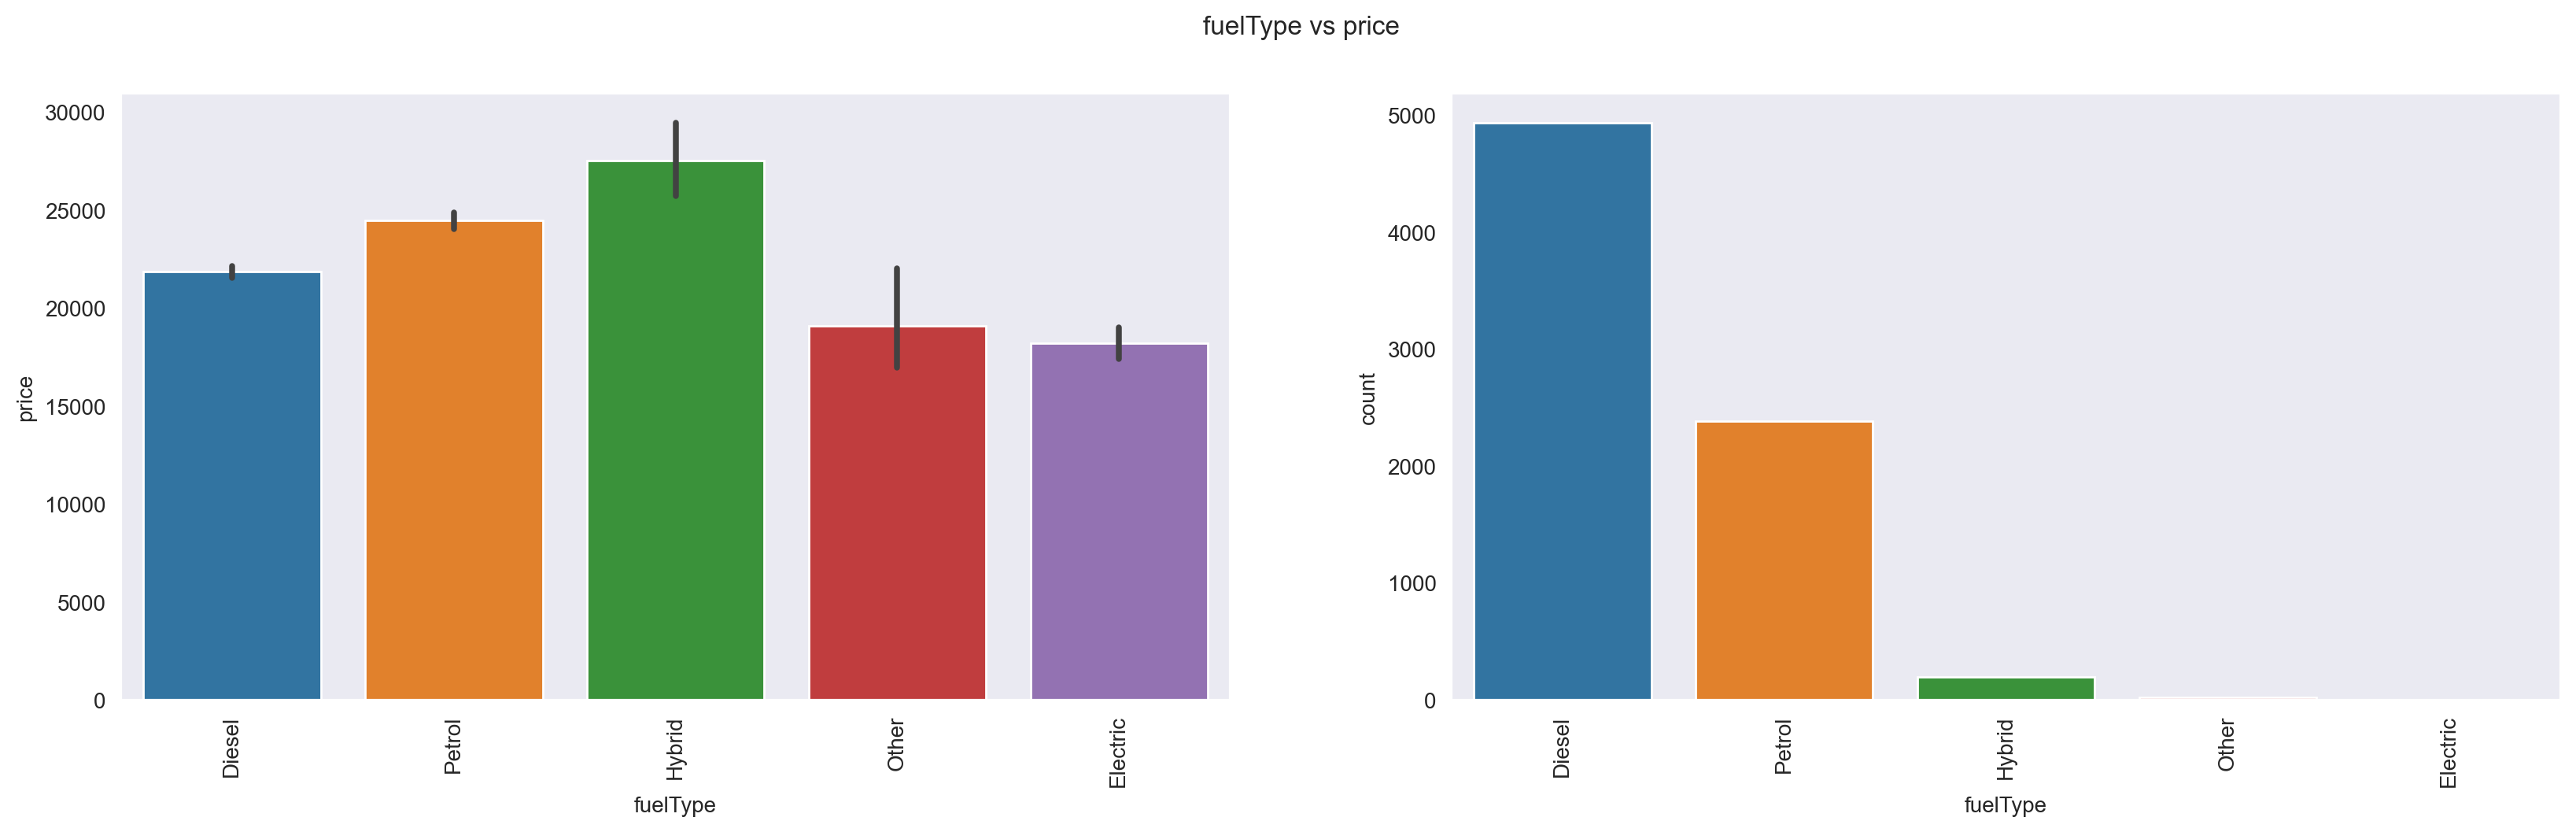

In [12]:
for col in cat_col:
    plot_(train, col)

In [13]:
#Manual has lower price than other transmission.
#Most of fuel type are Diesel and Petrol respectively and Diesel has lower price than others.

In [14]:
train = train.drop(train.price[train.price >= 100000].index)
pd.crosstab(train.model,train.fuelType, margins= True).style.background_gradient(cmap='Blues')

fuelType,Diesel,Electric,Hybrid,Other,Petrol,All
model,,,,,,
1 Series,785,0,0,0,563,1348
2 Series,382,0,24,2,466,874
3 Series,1219,0,60,12,411,1702
4 Series,473,0,0,0,225,698
5 Series,568,0,64,1,113,746
6 Series,53,0,0,0,16,69
7 Series,54,0,3,0,14,71
8 Series,14,0,0,0,15,29
M2,0,0,0,0,14,14


In [15]:
# Create age columns from year
now = datetime.datetime.now().year
train['age'] = now - train['year']
test['age'] = now - test['year']

# Change type
train['year'] = train['year'].apply(str)
test['year'] = test['year'].apply(str)

# Drop column year
data = [train,test]
for df in data:
    df.drop(columns = ['year'], inplace=True)

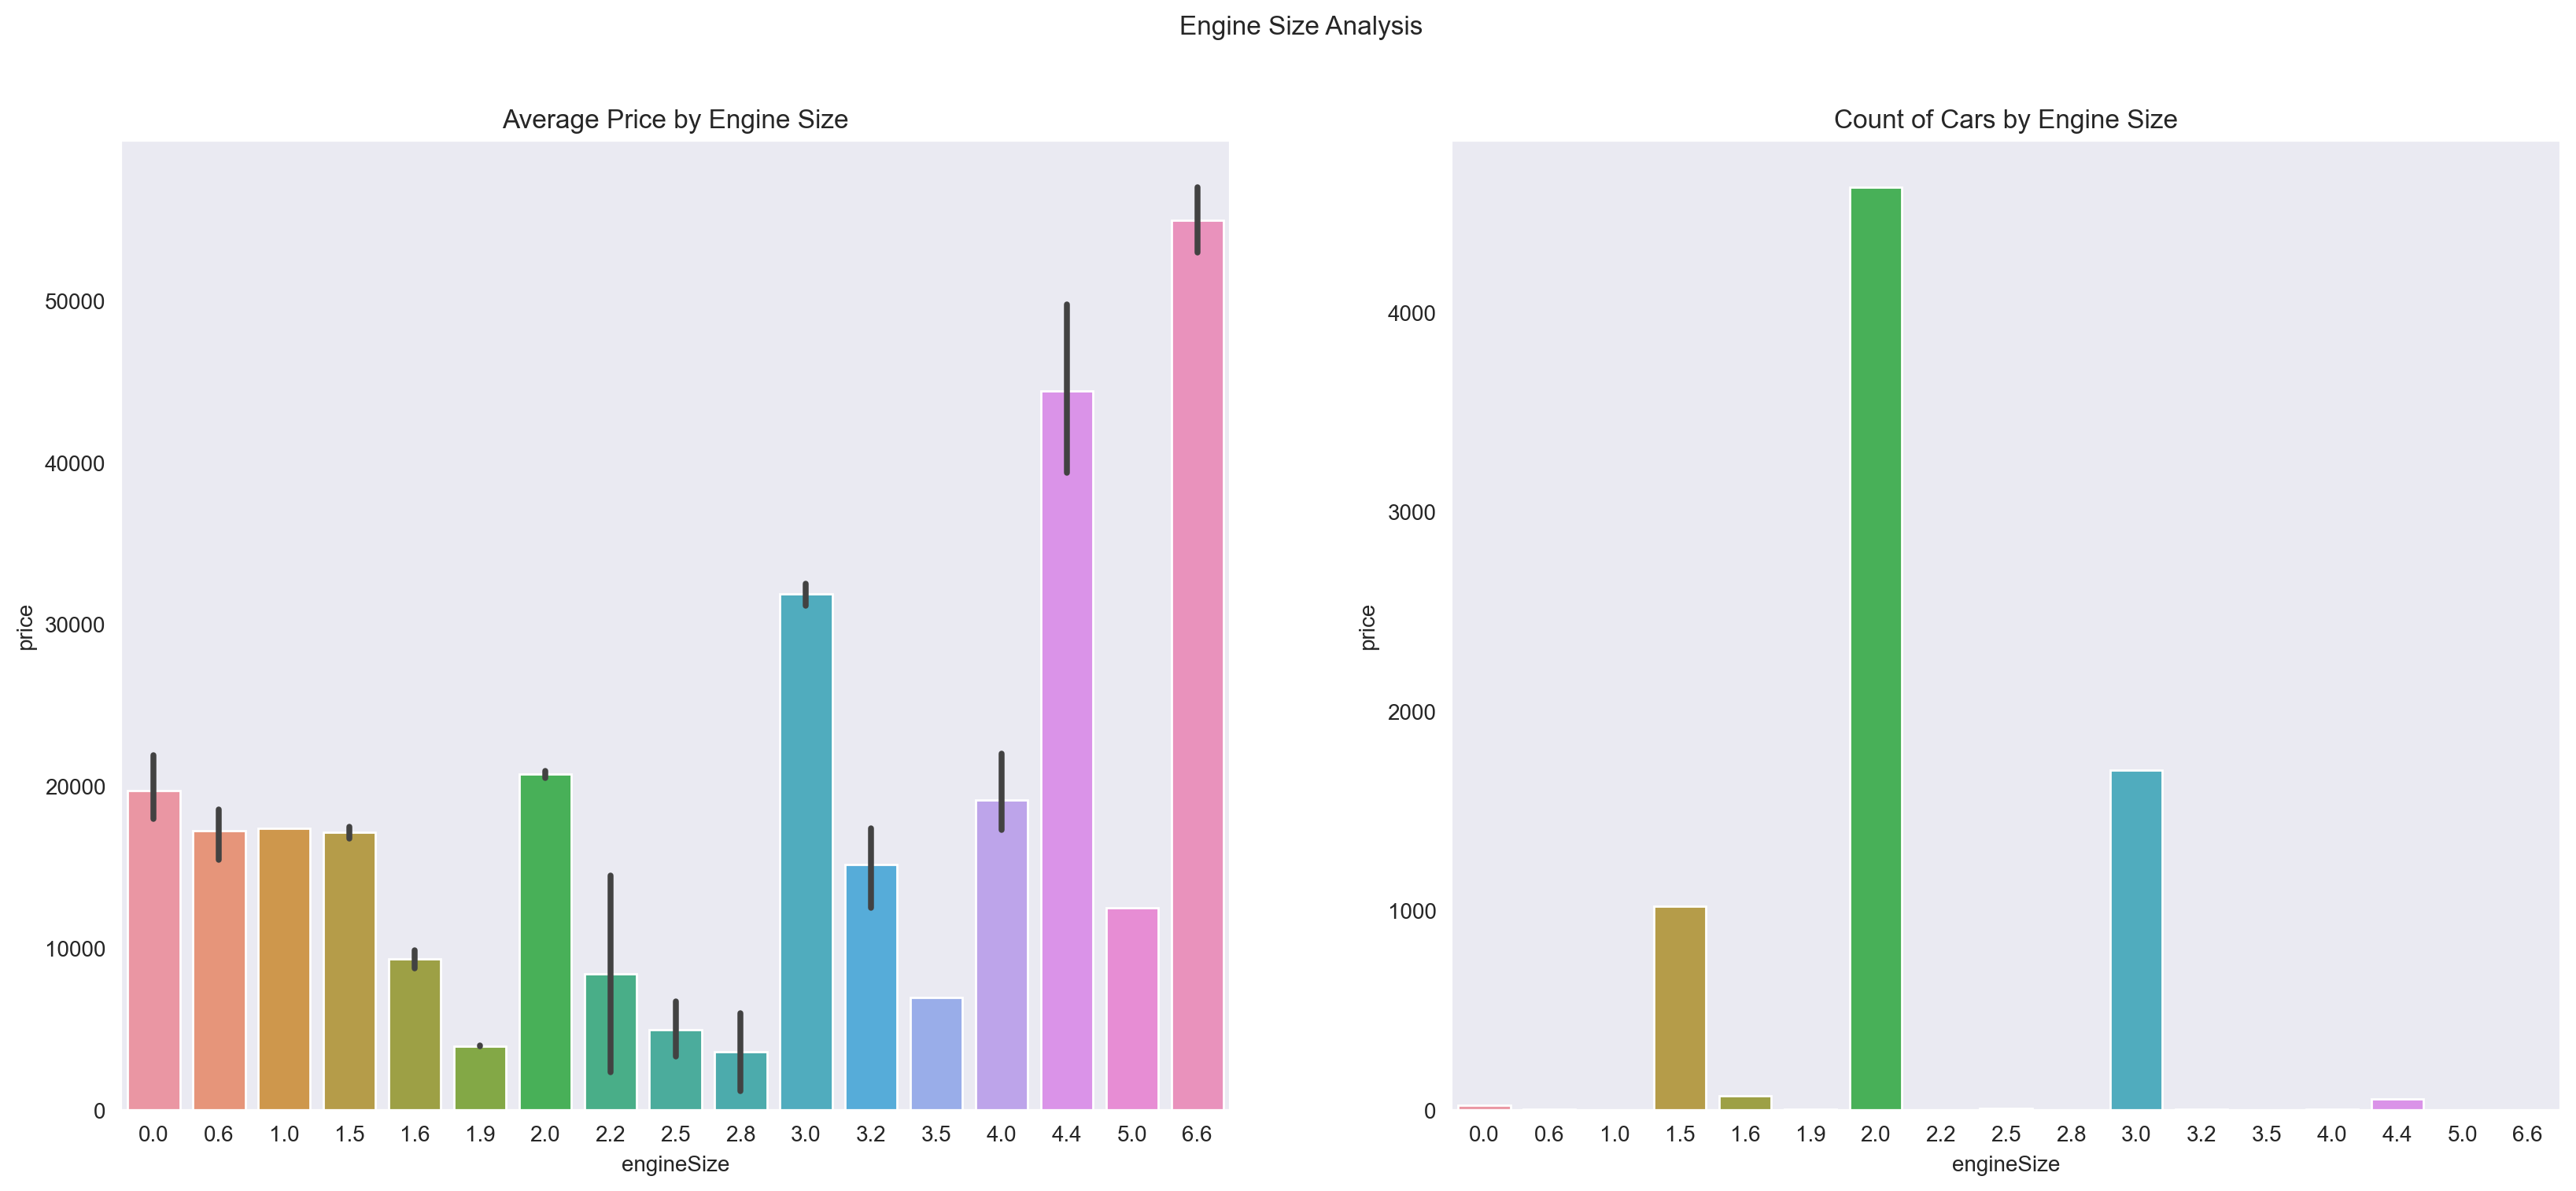

In [16]:


# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Barplot for engineSize vs. price
sns.barplot(x="engineSize", y="price", data=train, ax=ax[0])

# Barplot for engineSize count
sns.barplot(x="engineSize", y="price", data=train, ax=ax[1], estimator=len)

# Set titles for subplots
ax[0].set_title('Average Price by Engine Size')
ax[1].set_title('Count of Cars by Engine Size')

# Set common title for the figure
fig.suptitle('Engine Size Analysis')

# Show the plot
plt.show()



In [17]:
#Most of engineSize are 2.0, 3.0 and 1.5 respectively so we will group engineSize.

In [18]:
data = [train,test]
for df in data:
    df['engineSize'].replace([0.0, 0.6, 1.0], 1.5, inplace=True)
    df['engineSize'].replace([1.9, 2.2, 2.5], 2.0, inplace=True)
    df['engineSize'].replace([2.8, 3.2, 3.5], 3.0, inplace=True)
    df['engineSize'].replace([4.0, 4.4, 5.0, 6.6], 4.4, inplace=True)

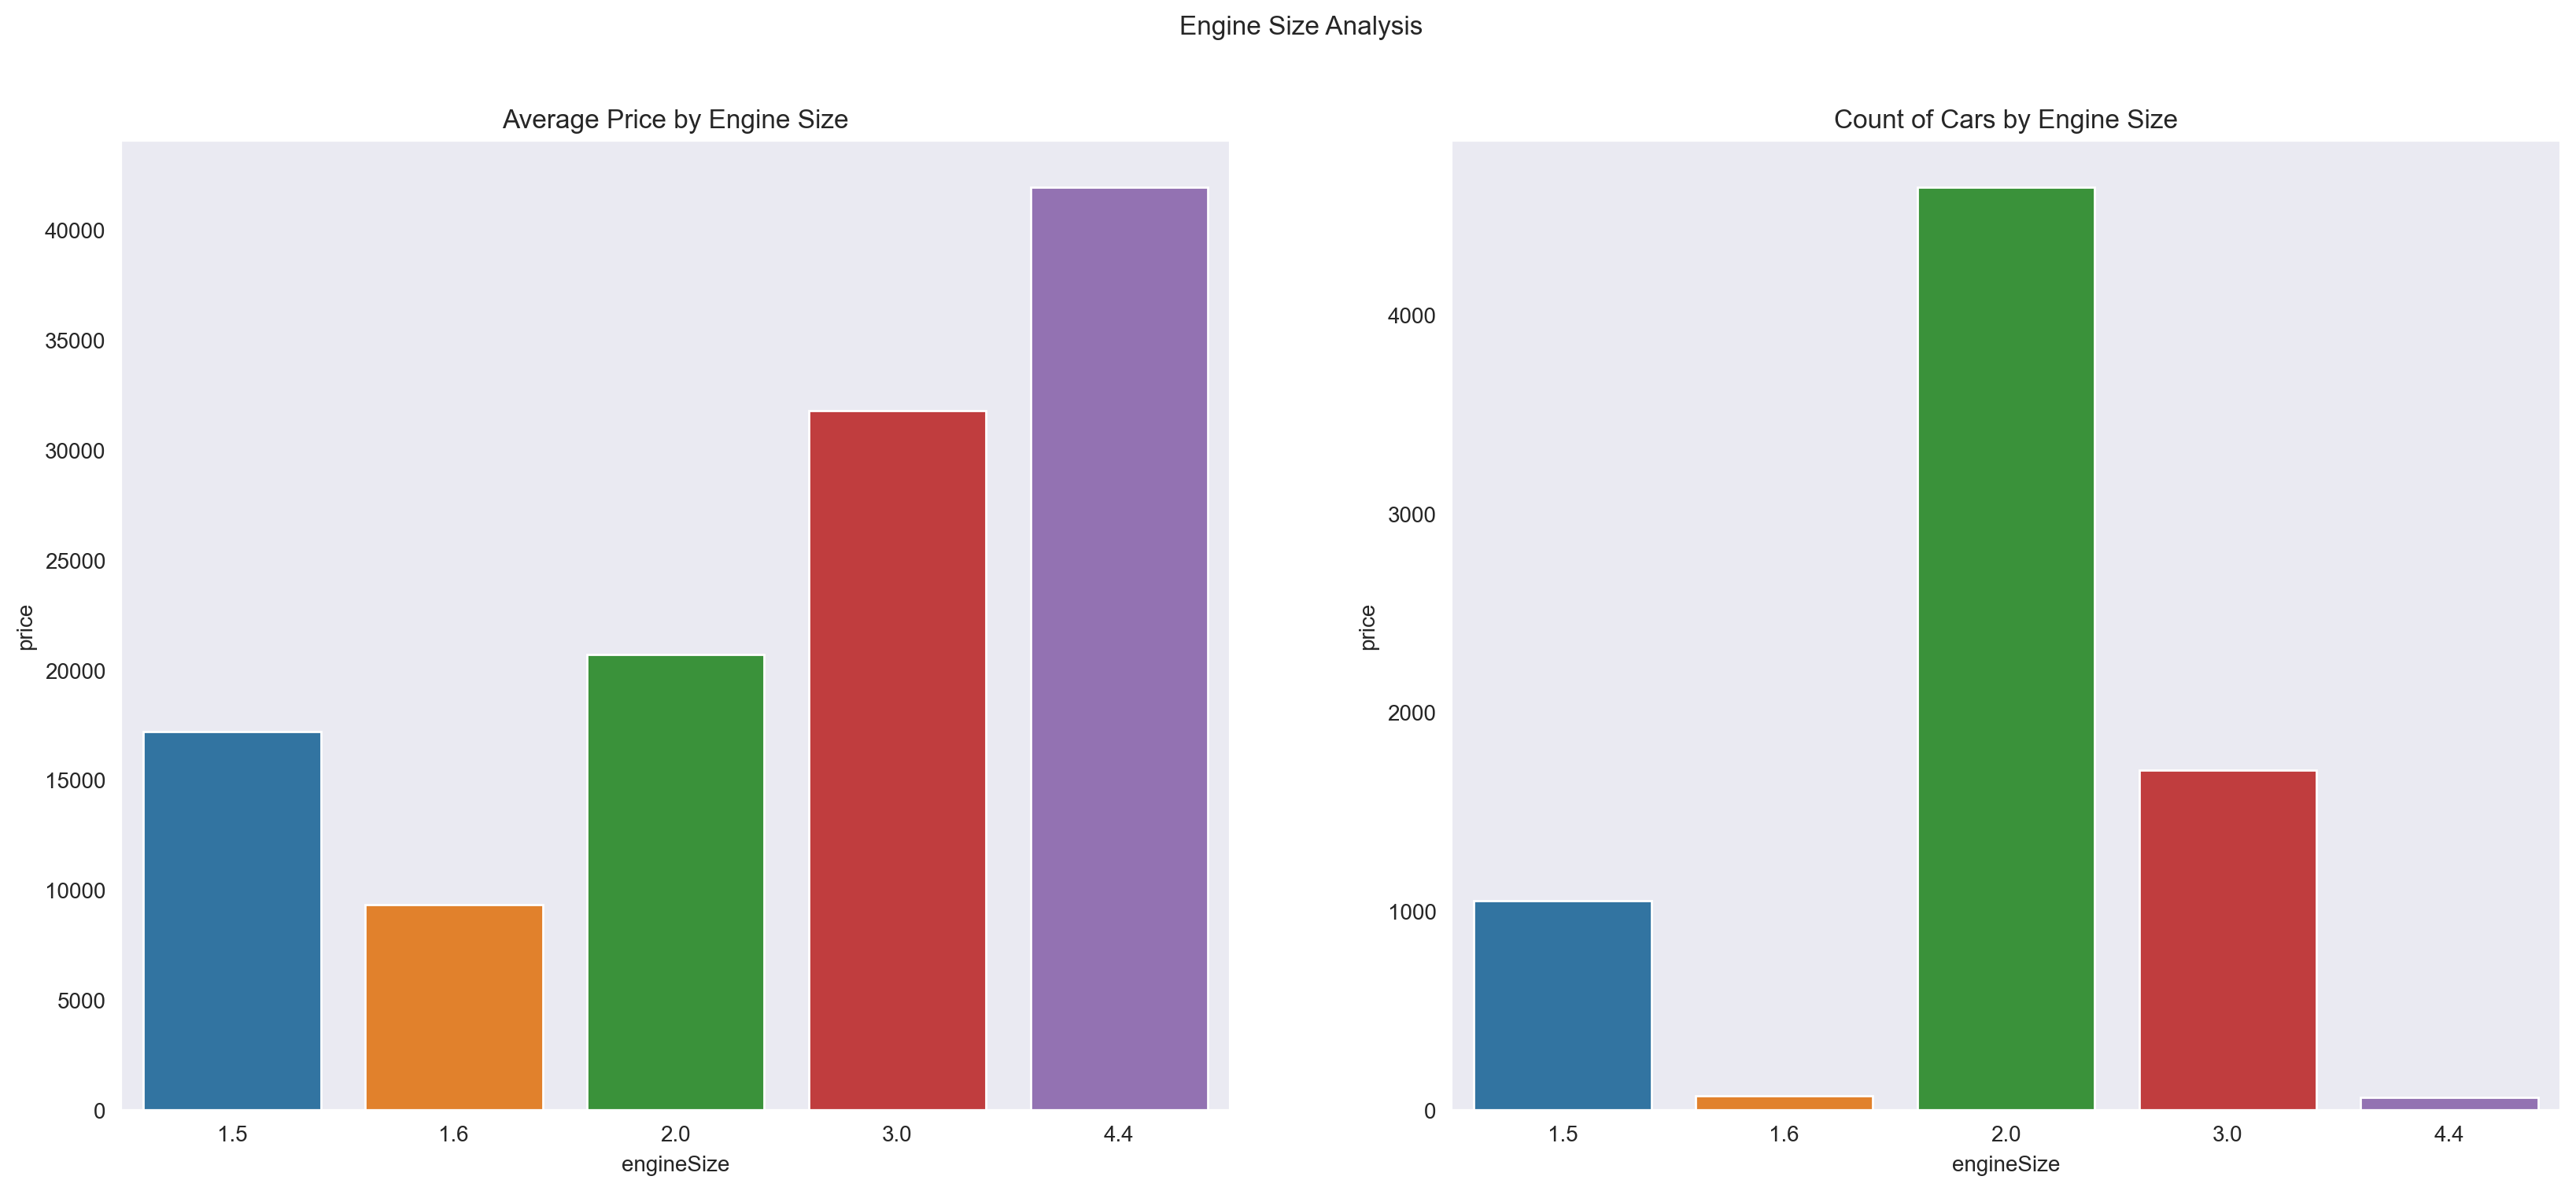

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Bar plot for average price by engineSize
sns.barplot(x="engineSize", y="price", data=train, ax=ax[0], ci=None)

# Bar plot for count of cars by engineSize
sns.barplot(x="engineSize", y="price", data=train, ax=ax[1], estimator=len, ci=None)

# Set titles for subplots
ax[0].set_title('Average Price by Engine Size')
ax[1].set_title('Count of Cars by Engine Size')

# Set common title for the figure
fig.suptitle('Engine Size Analysis')

# Show the plot
plt.show()

<Axes: xlabel='age', ylabel='price'>

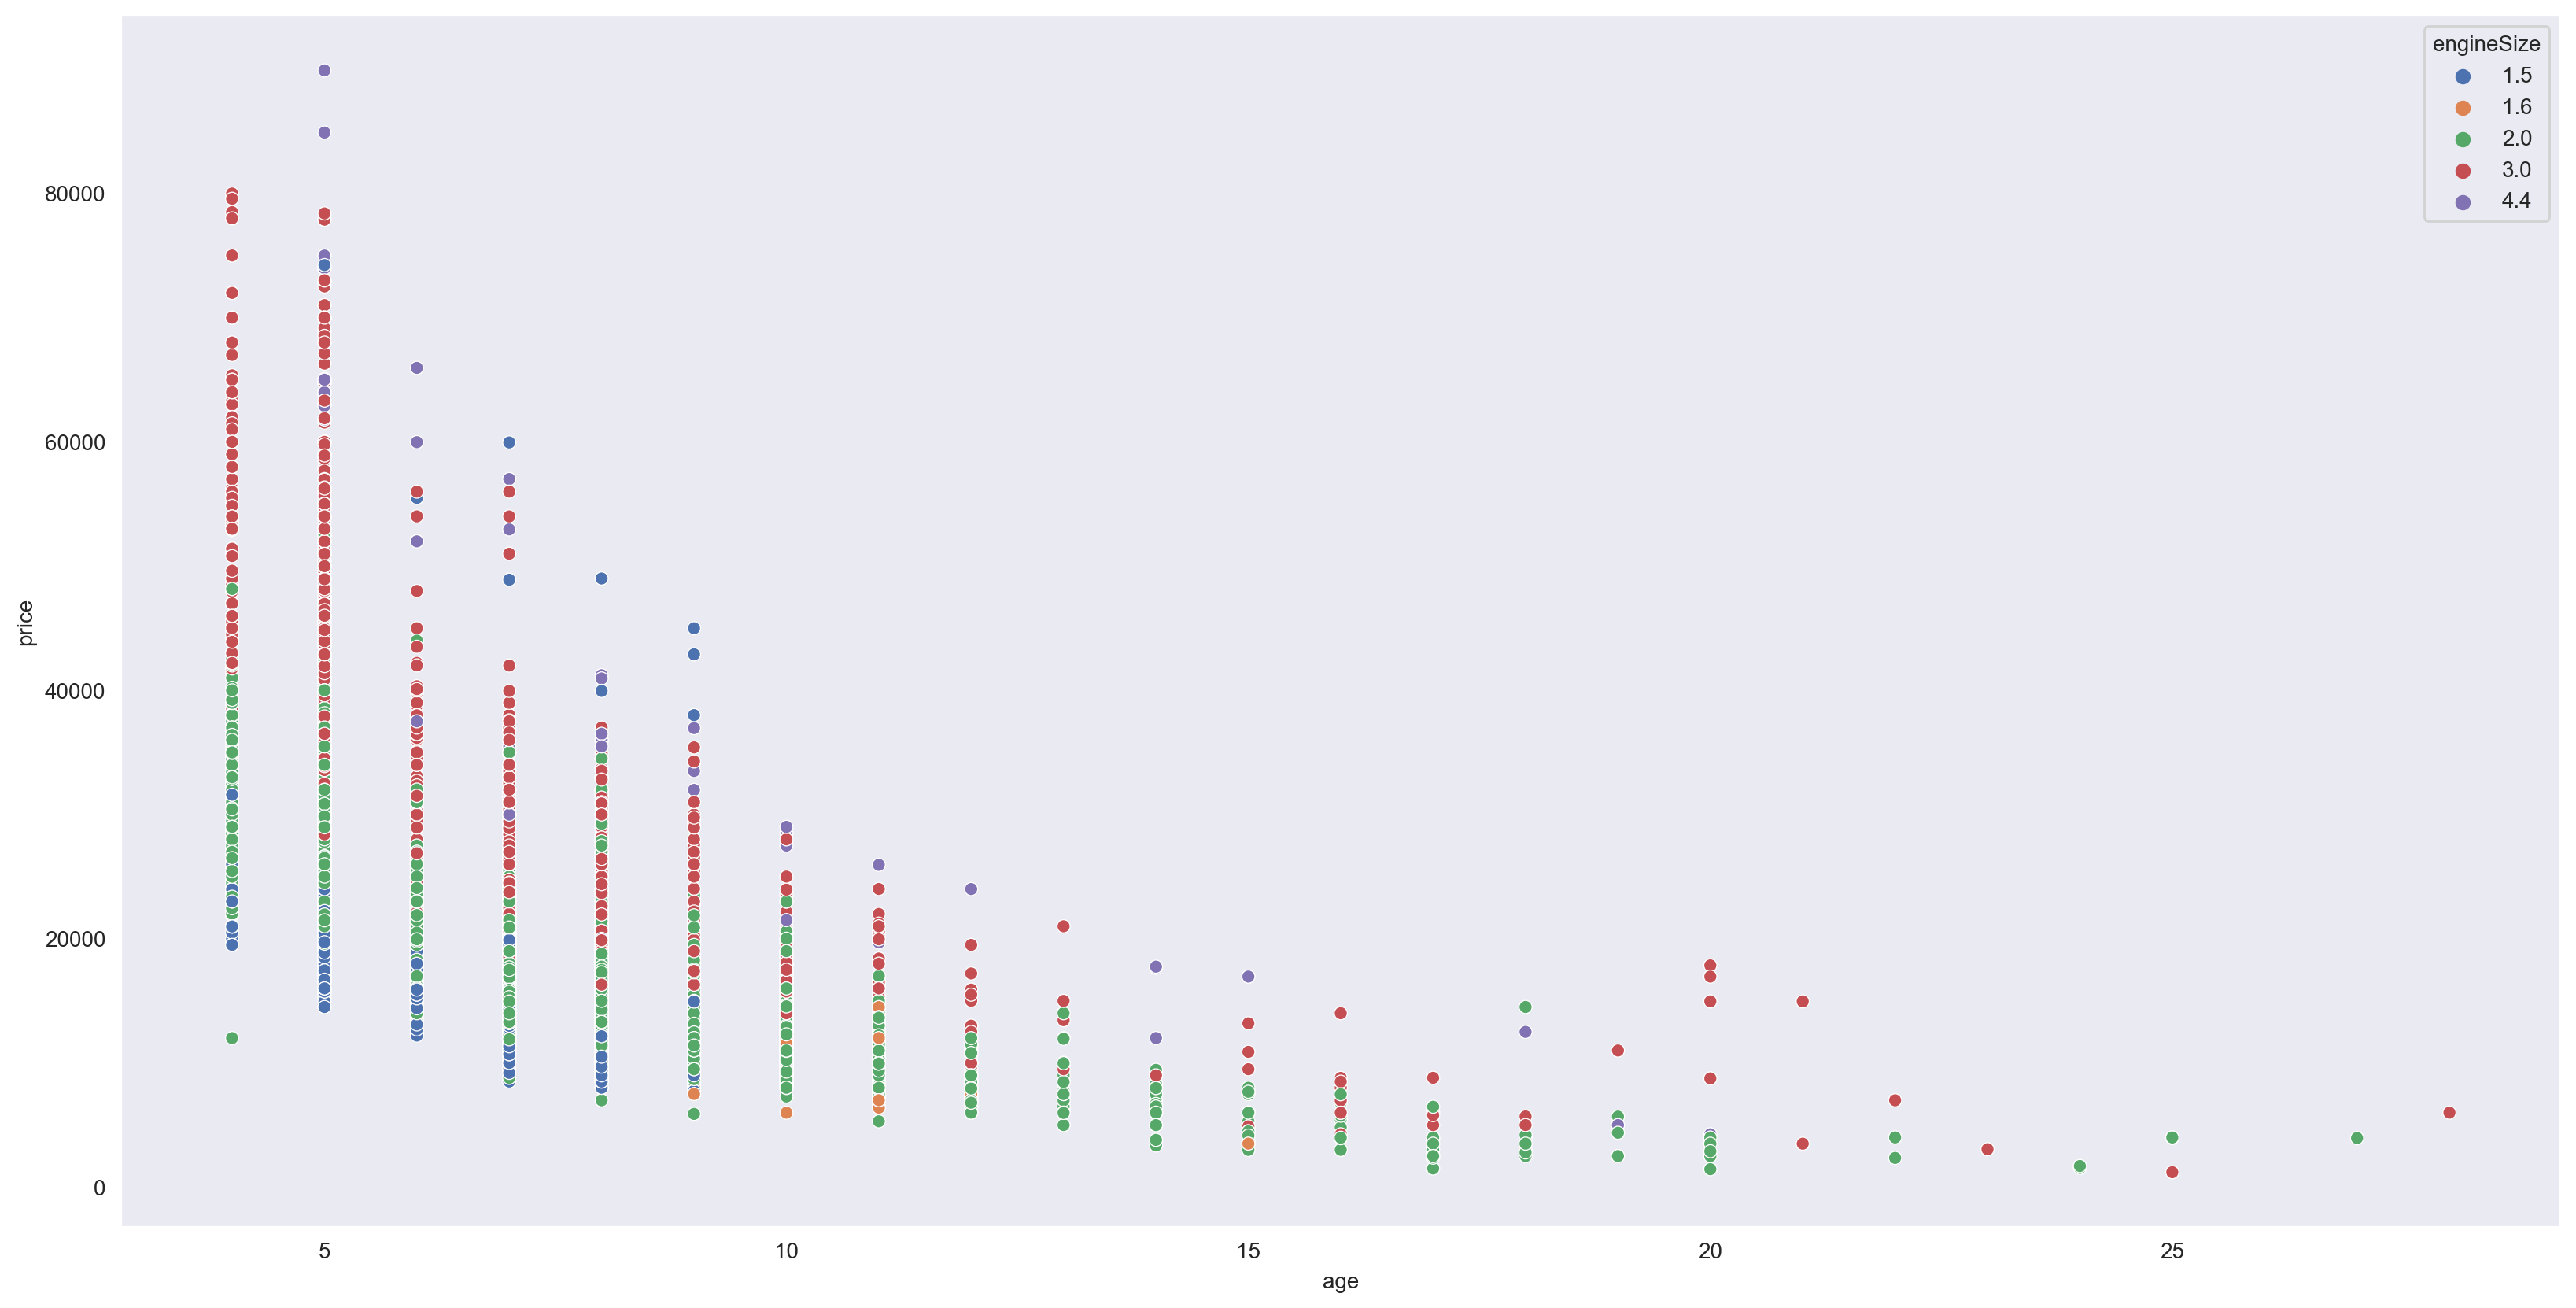

In [20]:
plt.figure(figsize=(20,10))

sns.scatterplot(data=train, x="age", hue='engineSize', y="price", palette="deep")

The higher age of car the price will go down.
At the same age if the  engineSize is larger the price will be 
higher.

In [21]:
data = [train,test]
for df in data:
    df['eng_age'] = df.engineSize / df.age
    df['mpg_eng'] = df.mpg / df.engineSize #fuel efficiency of the vehicle relative to its engine size. 
    #A higher value suggests better fuel efficiency for vehicles with smaller engines
    
    df['mpg_age'] = df.mpg / df.age  #indicates the fuel efficiency of the vehicle relative to its age
#could help in understanding how fuel efficiency changes over the lifespan of the vehicle

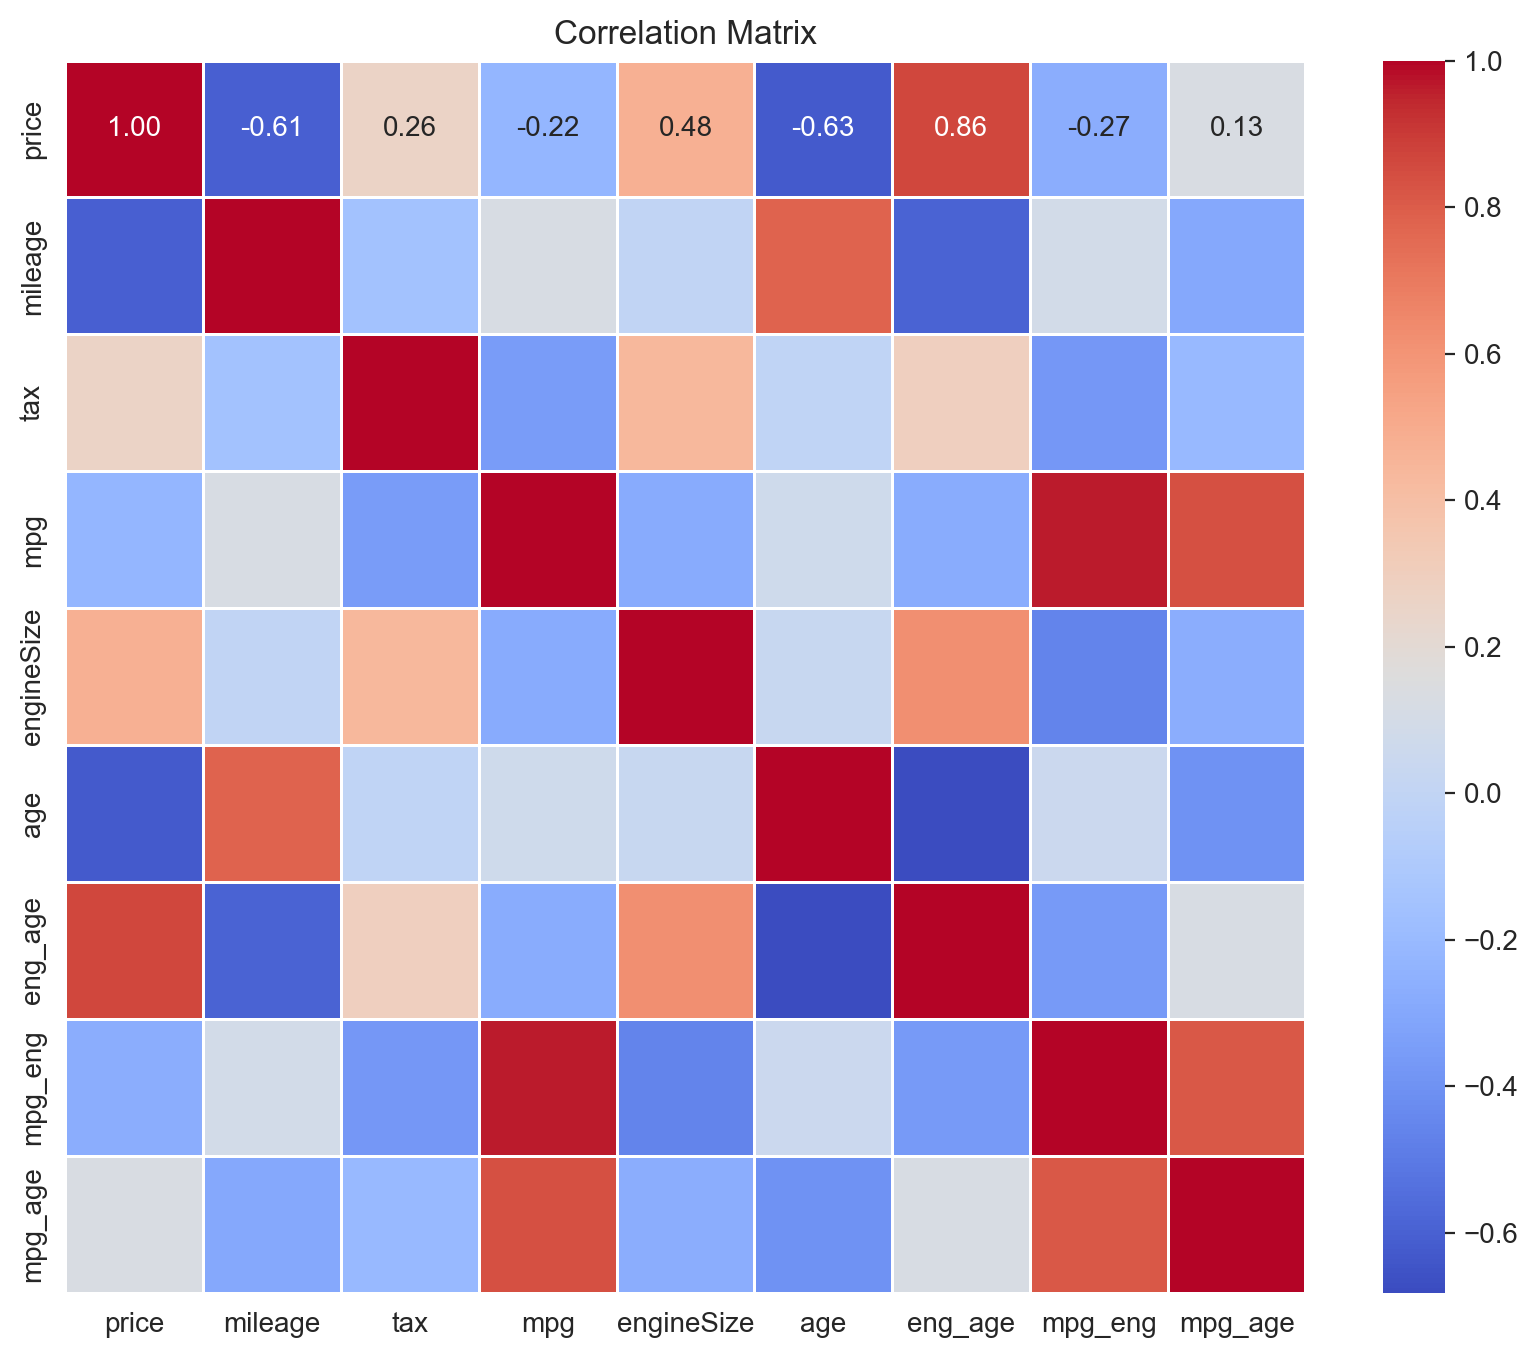

In [22]:
# Identify non-numeric columns
non_numeric_columns = train.select_dtypes(exclude=['number']).columns

# Drop non-numeric columns from the DataFrame
train_numeric = train.drop(columns=non_numeric_columns)

# Check for missing values in numeric columns
missing_values = train_numeric.isnull().sum()
if missing_values.any():
    # Handle missing values (e.g., by imputation)
    train_numeric.fillna(train_numeric.mean(), inplace=True)

# Compute correlation matrix
train_corr = train_numeric.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [23]:
# Log-Transform 
train.price = np.log1p(train.price)

X_train = train.drop(columns = 'price')
y_train = train.price

X_test = test.drop(columns = 'price')
y_test = test.price

In [24]:
# Get numerical columns
num_col = [col for col in X_train.columns if X_train[col].dtype != 'object']
print('Numerical Columns\n'+ str(num_col))

# Get categorical columns
cat_col = [col for col in X_train.columns if X_train[col].dtype == 'object']
print('\nCategorical Columns\n'+ str(cat_col))

Numerical Columns
['mileage', 'tax', 'mpg', 'engineSize', 'age', 'eng_age', 'mpg_eng', 'mpg_age']

Categorical Columns
['model', 'transmission', 'fuelType']


In [25]:
# Pipeline

# Numerical preprocess missing value
numerical_transformer = make_pipeline(RobustScaler())

# Categorical preprocess missing value
categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse=False))

# Preprocess Numerical and Categorical variable
preprocess = ColumnTransformer(transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)])

In [26]:
preprocess.fit_transform(X_train)

enc_cat_col = preprocess.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(input_features=cat_col)
labels = np.concatenate([num_col, enc_cat_col])
X_train_ = pd.DataFrame(preprocess.fit_transform(X_train), columns=labels)

preprocess.transform(X_test)

enc_cat_col = preprocess.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(input_features=cat_col)
labels = np.concatenate([num_col, enc_cat_col])
X_test_ = pd.DataFrame(preprocess.transform(X_test), columns=labels)

X_train_

#OneHotEncoder converts categorical variables into a binary representation, 
#creating a binary column for each category and representing the presence or absence of the category with a 1 or 0,

,mileage,tax,mpg,engineSize,age,eng_age,mpg_eng,mpg_age,model_1 Series,model_2 Series,...,model_i3,model_i8,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,-0.511523,0.0,-0.215116,0.0,-1.000000,1.111111,-0.177136,1.193020,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.173285,0.5,-0.267442,0.0,0.000000,-0.317460,-0.211055,-0.357652,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.426987,0.0,0.395349,0.0,-0.666667,0.444444,0.218593,1.084758,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.733567,-11.5,0.552326,0.0,0.333333,-0.555556,0.320352,-0.103276,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.686017,5.5,-0.360465,1.0,1.000000,-0.222222,-0.863065,-0.997863,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7540,-0.557865,0.0,-1.122093,1.0,-1.000000,2.777778,-1.192211,0.081909,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7541,-0.390682,0.0,0.395349,0.0,-0.666667,0.444444,0.218593,1.084758,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7542,-0.131807,0.5,-0.058140,-0.5,-0.333333,-0.555556,0.581658,0.143637,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7543,0.681061,-11.5,0.813953,0.0,0.000000,-0.317460,0.489950,0.399369,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
#MODEL
#provides a more reliable estimate of the model's performance compared to a single train-test split,
#especially when the dataset is limited in size.

kf =KFold(n_splits=5, shuffle=True, random_state=21)

print('='*30 +'BASE MODEL' + '='*30)
lar = LinearRegression()
lar.fit(X_train_, y_train)
print('\n')

RMSE = -1*cross_val_score(lar, X_train_, y_train, cv=kf, scoring='neg_root_mean_squared_error')

print(f'RMSE: {RMSE.mean():.5f} ±{RMSE.std():.3f}' )

#A lower RMSE indicates better model performance.

==============================BASE MODEL==============================


RMSE: 0.12260 ±0.004


 Estimate the model's performance on unseen data by repeatedly training and testing the model on different subsets of the training data


model's stability and variability in performance.

==============================RMSE TRAIN MODEL==============================
RandomForestRegressor     0.10596 ±0.003
GradientBoostingRegressor 0.11652 ±0.003
XGBoost                   0.09862 ±0.005
AVERAGE SCORE RMSE: 0.10703


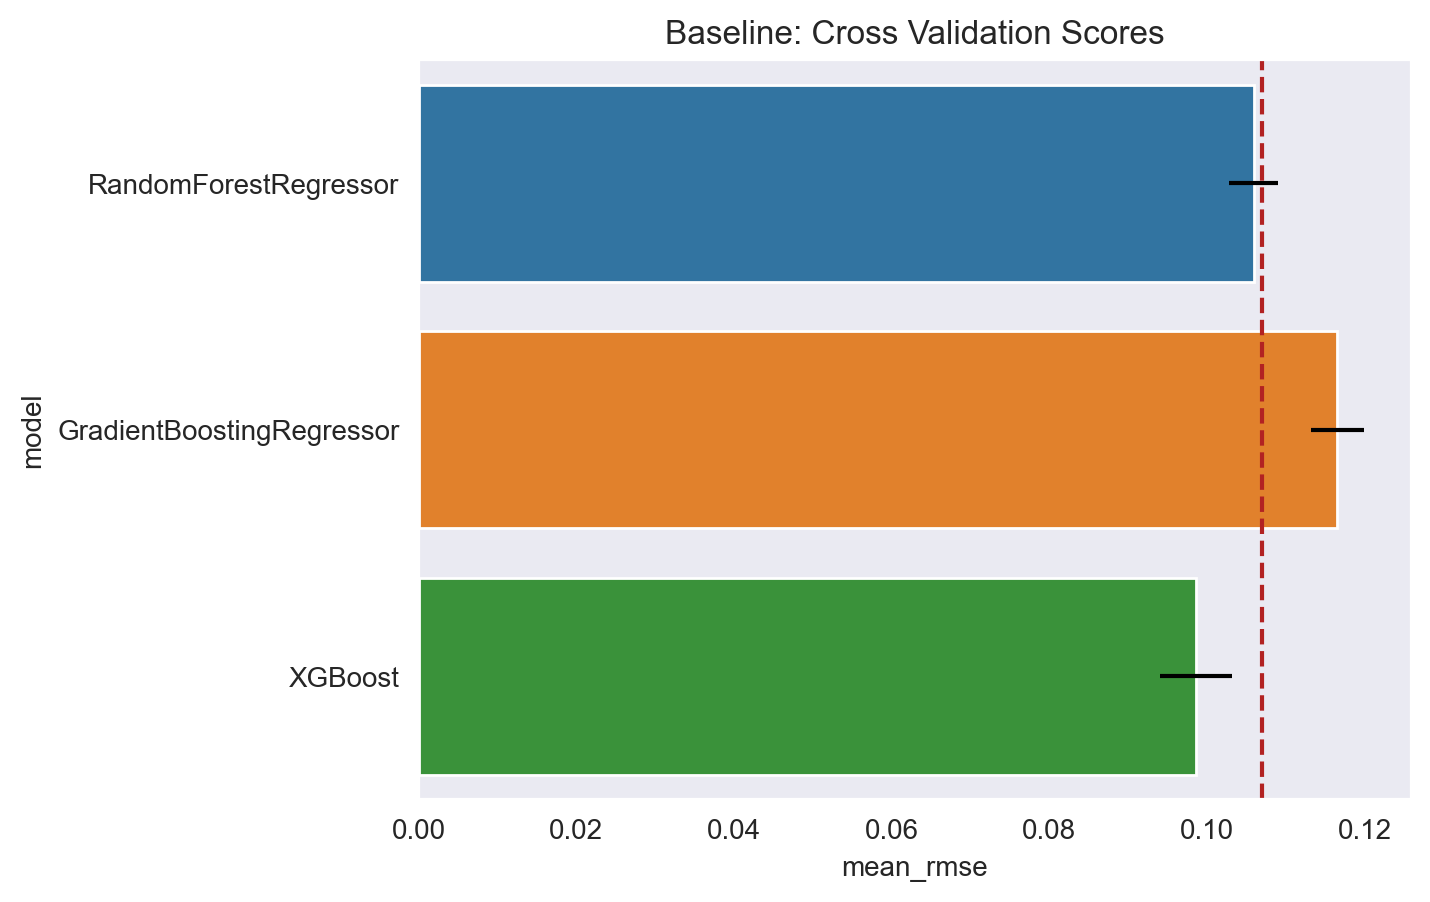

In [28]:
models = [
    ('RandomForestRegressor', RandomForestRegressor()),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ("XGBoost", XGBRegressor())
]

# Print header for RMSE train model
print('='*30 + 'RMSE TRAIN MODEL' + '='*30)

# Initialize lists to store results
mean_rmse = []
sd_rmse = []
model_name = []

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Data preprocessing and model training loop
for name, model in models:
    model.fit(X_train_, y_train)
    RMSE = -1 * cross_val_score(model, X_train_, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    print(f'{name:<25} {RMSE.mean():.5f} ±{RMSE.std():.3f}')
    
    mean_rmse.append(RMSE.mean())
    sd_rmse.append(RMSE.std())
    model_name.append(name)

# Calculate average RMSE
print('AVERAGE SCORE RMSE: {:.5f}'.format(np.mean(mean_rmse)))

# Create DataFrame to visualize results
base = pd.DataFrame({'model': model_name, 'mean_rmse': mean_rmse, 'sd_rmse': sd_rmse})

# Plot bar chart of RMSE scores
sns.barplot(x="mean_rmse", y="model", data=base, orient='h', **{'xerr': sd_rmse})
plt.title('Baseline: Cross Validation Scores')
plt.axvline(x=np.mean(mean_rmse), color='firebrick', linestyle='--')




In [29]:
model_RF = RandomForestRegressor()

# Defined the parameters of the model which we want to pass to through RandomizedSearchCV
parameters_RF = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
RF_random_search = RandomizedSearchCV(model_RF, parameters_RF, cv=kf, scoring='neg_mean_absolute_error', verbose=False, n_jobs=-1, return_train_score=True)

# Fit RandomizedSearchCV
RF_random_search.fit(X_train_, y_train)

# Print the best estimator
print("Best Random Forest Estimator:")
print(RF_random_search.best_estimator_)

# Evaluate the best model
RMSE_RF = -1 * cross_val_score(RF_random_search.best_estimator_, X_train_, y_train, cv=kf, scoring='neg_root_mean_squared_error')
print('SCORE RMSE: {:.5f} ±{:.3f}'.format(RMSE_RF.mean(), RMSE_RF.std()))

# Display feature importances
feature_imp_RF = pd.DataFrame(RF_random_search.best_estimator_.feature_importances_, X_train_.columns, columns=['Feature_Importances']).sort_values(by='Feature_Importances', ascending=False)


Best Random Forest Estimator:
RandomForestRegressor(max_depth=15, n_estimators=300)
SCORE RMSE: 0.10584 ±0.003


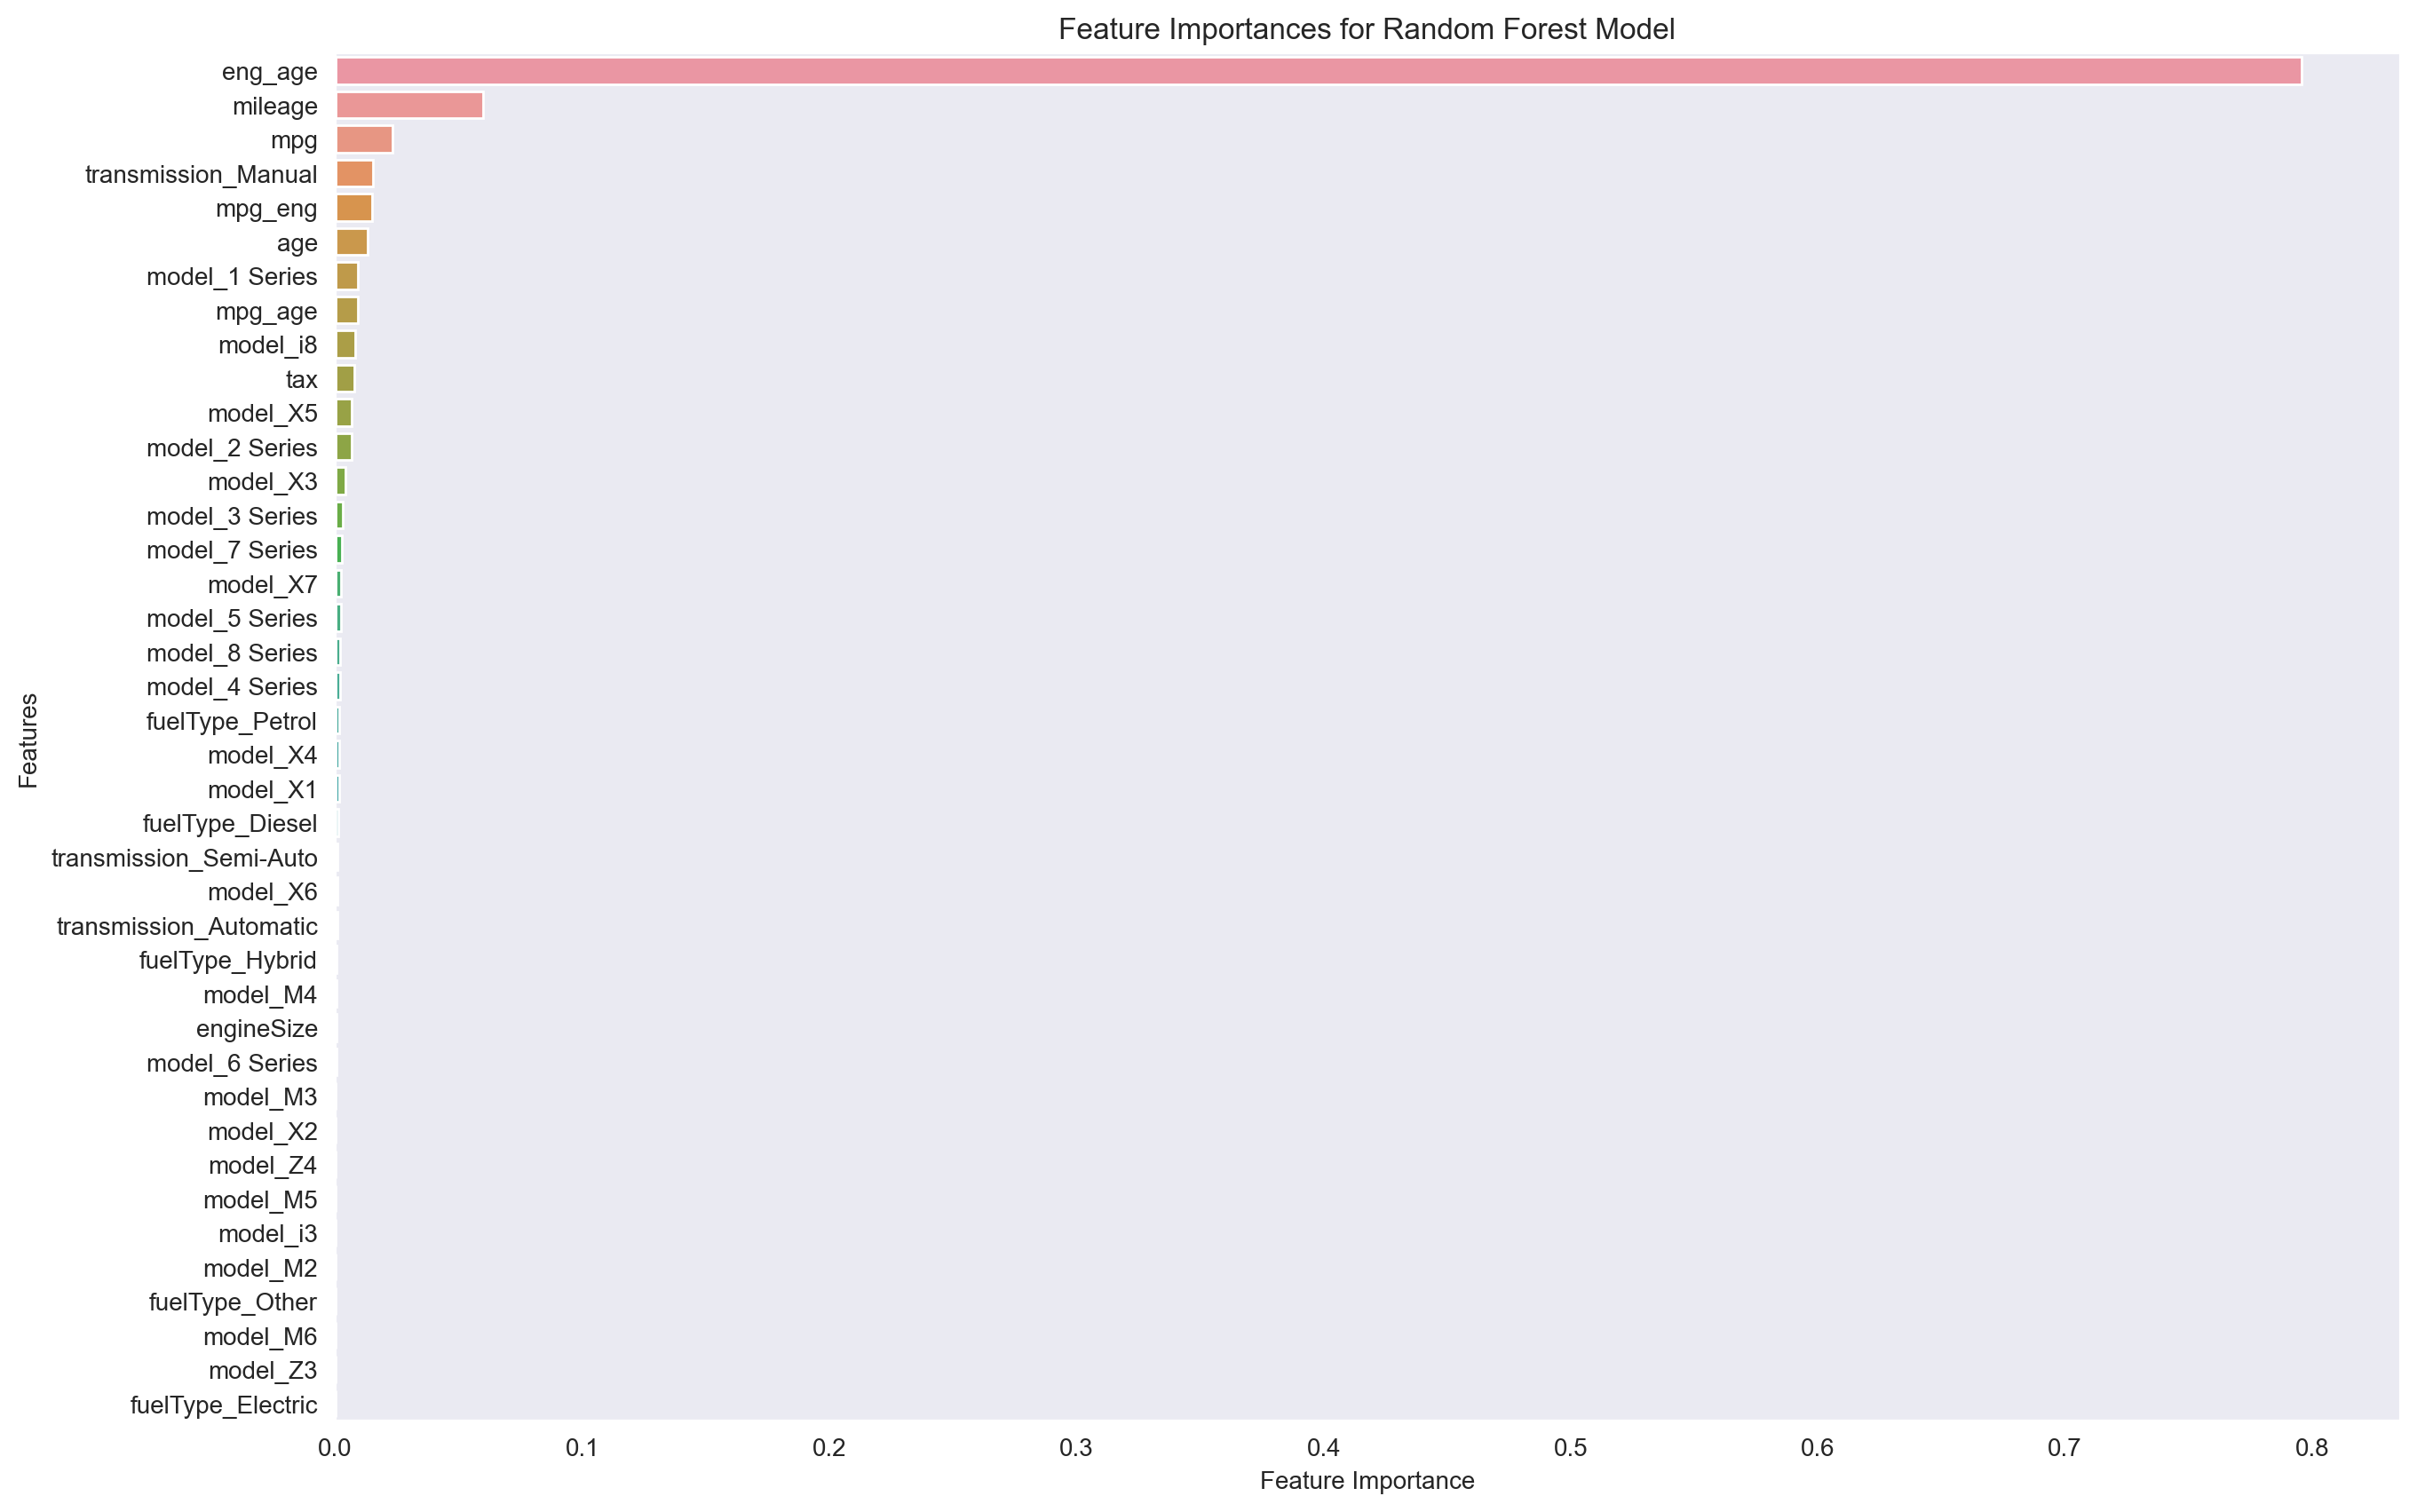

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="Feature_Importances", y=feature_imp_RF.index, data=feature_imp_RF, ax=ax)
ax.set_title('Feature Importances for Random Forest Model')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
plt.show()


The engineSize/age of car is the higest importance and follow by the mileage and mpg/engineSize......
The larger engineSize the price is higher, the older cars (higher age) the price are cheaper......
The higher mileage, mpg price will drop.

In [31]:
# Make predictions with the best Random Forest model
predictions_RF = RF_random_search.best_estimator_.predict(X_test_)

# Convert predictions back to the original scale if necessary
# In this example, it's assumed that the target variable was transformed using np.expm1, so we need to apply np.expm1 to the predictions
y_pred_RF = np.expm1(predictions_RF)

# Create a Series with the predicted prices
predicted_prices_RF = pd.Series(y_pred_RF, name='price_predict')

# Concatenate actual prices, predicted prices, and features from the test set
compare_RF = pd.concat([y_test.reset_index(drop=True), predicted_prices_RF, X_test.reset_index(drop=True)], axis='columns')

# Display a sample of the resulting DataFrame
print(compare_RF.sample(100))


      price  price_predict      model transmission  mileage fuelType  tax  \
1638  27500   26776.164578   5 Series    Semi-Auto     7095   Petrol  150   
485   20990   21825.635316   2 Series    Semi-Auto       10   Petrol  145   
2748  11495   10885.753441   2 Series       Manual    41388   Diesel   20   
1470  24898   26852.622956   3 Series    Semi-Auto    13125   Diesel  145   
3038  20995   18032.255244   5 Series    Semi-Auto    23116   Diesel   30   
...     ...            ...        ...          ...      ...      ...  ...   
135   19999   18619.979437   6 Series    Automatic    41963   Diesel  160   
644   18790   18800.659165   4 Series    Automatic    36207   Diesel  145   
1752  26495   27077.106231   1 Series    Semi-Auto       10   Petrol  145   
1730  13300   12523.627841   4 Series    Automatic    83359   Diesel   30   
2072  17500   21746.676282   1 Series    Automatic    24299   Petrol  235   

       mpg  engineSize  age   eng_age    mpg_eng    mpg_age  
1638  50.4   

In [32]:
# Define the conditions for filtering out the rows
condition_1 = (compare_RF.price >= 50000) & (compare_RF.price_predict <= 37000)
condition_2 = (compare_RF.price >= 40000) & (compare_RF.price_predict <= 20000)
condition_3 = (compare_RF.price >= 80000) & (compare_RF.price_predict <= 50000)

# Get the indices that satisfy any of the conditions
index_out = compare_RF[condition_1 | condition_2 | condition_3].index.tolist()

# Filter out the rows using the obtained indices
filtered_compare_RF = compare_RF.iloc[index_out]

# Display the filtered DataFrame
print(filtered_compare_RF)


      price  price_predict      model transmission  mileage fuelType  tax  \
56    99950   29289.723486         M4    Automatic      771   Petrol  300   
368   72000   27084.965302         i8    Automatic      176   Hybrid  135   
377   57870   21746.523091         i8    Automatic    11278   Hybrid  135   
603   76990   29490.034433         M4    Automatic     4550   Petrol  300   
787   67500   24301.876414         i8    Automatic     6000   Hybrid  140   
1686  52495   19118.881502         i8    Automatic    17580   Hybrid    0   
2234  64980   22525.130470         i8    Automatic     4477   Hybrid  135   
2260  43497   12561.853519         i8    Automatic    41237   Hybrid    0   
2272  56950   35853.004877   8 Series    Semi-Auto     9731   Diesel  145   
2760  67940   27137.461135         i8    Automatic     1110   Hybrid  135   
3170  89990   43563.336272         M4    Semi-Auto     1336   Petrol  145   

        mpg  engineSize  age   eng_age    mpg_eng    mpg_age  
56     33.2 

The i8 and M4 ,8 Series model that have a high error so we have to deliberate when we use this model to predict price of car.